In [1]:
import numpy as np
from ripser import ripser
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from persim import plot_diagrams
from sklearn.decomposition import PCA

from scipy.interpolate import InterpolatedUnivariateSpline

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

In [2]:
import cv2
capture = cv2.VideoCapture('/Users/jamesmcgloin/Downloads/opencvdemo.mp4')
y_vals = []

In [59]:
capture.read()
while capture.isOpened():
    _, img_1 = capture.read()
    _, img_2 = capture.read()
    if img_1 is None or img_2 is None:
        break

    # find difference between two frames
    diff = cv2.absdiff(img_1, img_2)

    # to convert the frame to grayscale
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # apply some blur to smoothen the frame
    diff_blur = cv2.GaussianBlur(diff_gray, (91, 91), 0)

    # to get the binary image
    _, thresh_bin = cv2.threshold(diff_blur, 100, 255, cv2.THRESH_BINARY)

    # to find contours
    contours, hierarchy = cv2.findContours(thresh_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # to draw the bounding box when the motion is detected
    y_cord = []
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        if (cv2.contourArea(contour) > 100) and (cv2.contourArea(contour) < 50000):
            cv2.rectangle(img_1, (x, y), (x+w, y+h), (0, 255, 0), 2)
            y_cord.append(y)
    # cv2.drawContours(img_1, contours, -1, (0, 255, 0), 2)
    if y_cord:
        y_vals.append(min(y_cord))
    # display the output
    cv2.imshow("Detecting Motion...", img_1)
    if cv2.waitKey(100) == 13:
        exit()

In [3]:
def getSlidingWindow(x, dim, Tau, dT):
    """
    Return a sliding window of a time series,
    using arbitrary sampling.  Use linear interpolation
    to fill in values in windows not on the original grid
    Parameters
    ----------
    x: ndarray(N)
        The original time series
    dim: int
        Dimension of sliding window (number of lags+1)
    Tau: float
        Length between lags, in units of time series
    dT: float
        Length between windows, in units of time series
    Returns
    -------
    X: ndarray(N, dim)
        All sliding windows stacked up
    """
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim))
    spl = InterpolatedUnivariateSpline(np.arange(N), x)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        # Only take windows that are within range
        if end >= len(x):
            X = X[0:i, :]
            break
        X[i, :] = spl(idxx)
    return X

<IPython.core.display.Javascript object>


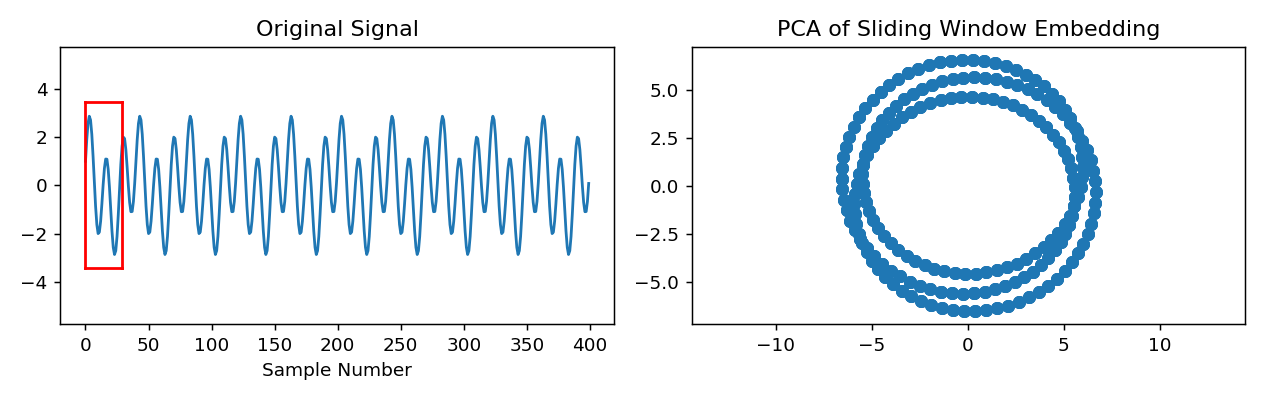

lambda1 = 20.101, lambda2 = 20.0002
lambda1 = 21.3744, lambda2 = 19.3245
lambda1 = 21.3885, lambda2 = 18.935
lambda1 = 20.893, lambda2 = 19.4918
lambda1 = 20.8777, lambda2 = 19.4548
lambda1 = 20.5118, lambda2 = 20.0448
lambda1 = 16.5036, lambda2 = 16.233
lambda1 = 11.3989, lambda2 = 9.05606
lambda1 = 8.67716, lambda2 = 6.54465
lambda1 = 18.4388, lambda2 = 16.2846


In [25]:
def on_value_change(change):
    execute_computation1()
    
dimslider = widgets.IntSlider(min=1,max=40,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

dTslider = widgets.FloatSlider(min=0.1,max=5,step=0.5,value=1,description='dT: ',continuous_update=False)
dTslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider,dTslider)))

plt.figure(figsize=(9.5, 3))
def execute_computation1():    
    plt.clf()
    # Step 1: Setup the signal again in case x was lost
    T = 40 # The period in number of samples
    NPeriods = 10 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t)+2*np.sin(3*t) # The final signal
    
    # Get slider values
    dim = dimslider.value
    Tau = Tauslider.value
    dT = dTslider.value
    
    #Step 2: Do a sliding window embedding
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_
    print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

    #Step 4: Plot original signal and PCA of the embedding
    ax = plt.subplot(121)
    ax.plot(x)
    ax.set_ylim((-2*max(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')     
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')
    ax2 = plt.subplot(122)
    ax2.set_title("PCA of Sliding Window Embedding")
    ax2.scatter(Y[:, 0], Y[:, 1])
    ax2.set_aspect('equal', 'datalim')
    plt.tight_layout()
    
execute_computation1()

In [19]:
T = 40 # The period in number of samples
NPeriods = 10 # How many periods to go through
N = T*NPeriods # The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
x = np.cos(t)+np.sin(1/2*t) # The final signal
# Get slider values
dim = dimslider.value
Tau = Tauslider.value
dT = dTslider.value

Computing persistence diagrams for g1...


<IPython.core.display.Javascript object>


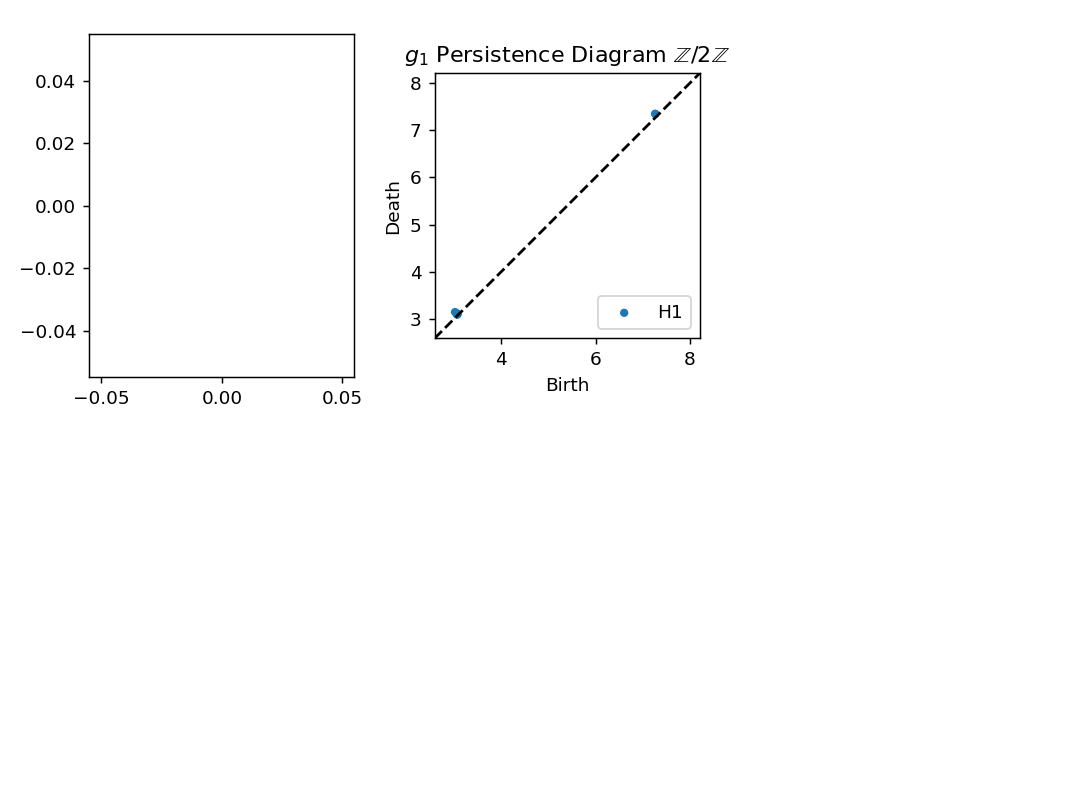

In [24]:
X1 = getSlidingWindow(x, dim, Tau, dT)

#Step 1: Do rips filtrations with different field coefficients
print("Computing persistence diagrams for g1...")
PDs1_2 = ripser(X1, maxdim=2)['dgms'] #Z2 Coefficients
#PDs1_3 = ripser(X1, maxdim=1, coeff=3)['dgms'] #Z3 Coefficients


fig = plt.figure(figsize=(8, 6))

plt.subplot(231)
plt.plot(y_vals[5:200])

plt.subplot(232);
plot_diagrams(PDs1_2[2], labels=['H1'])
plt.title("$g_1$ Persistence Diagram $\mathbb{Z}/2\mathbb{Z}$")

# plt.subplot(233);
# plot_diagrams(PDs1_2[1], labels=['H1'])
# plt.title("$g_1$ Persistence Diagram $\mathbb{Z}/3\mathbb{Z}$")



plt.tight_layout();

<IPython.core.display.Javascript object>


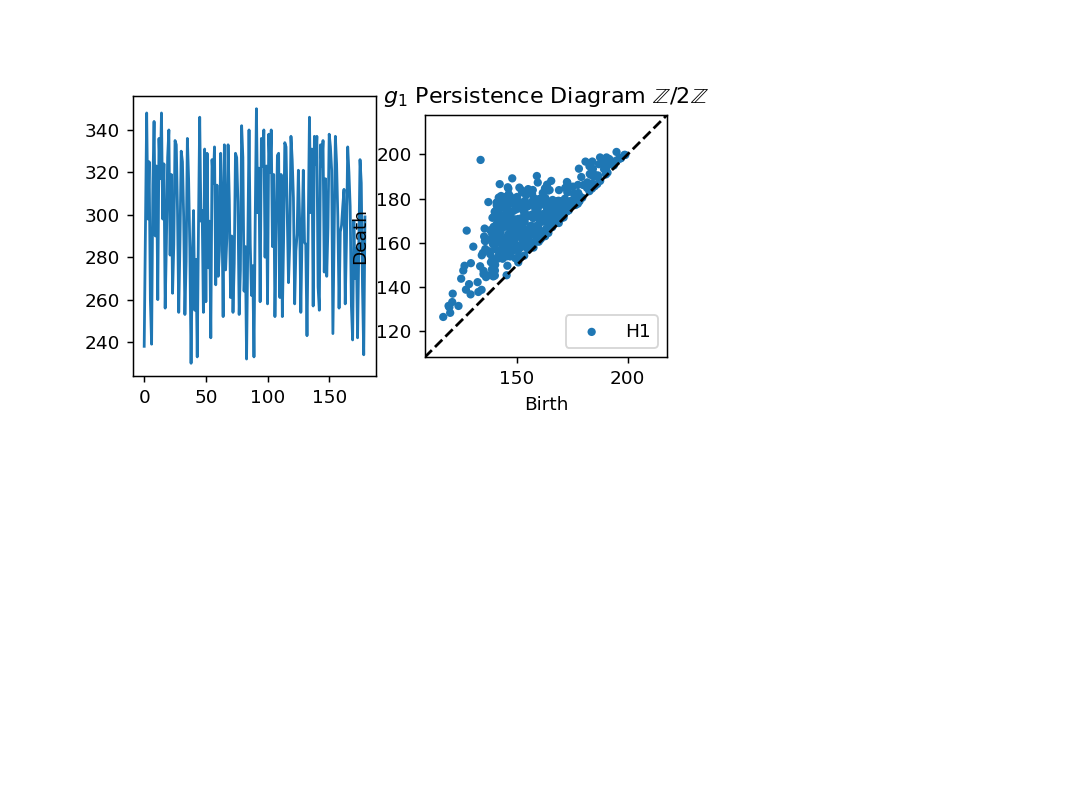

Text(0.5, 1.0, '$g_1$ Persistence Diagram $\\mathbb{Z}/2\\mathbb{Z}$')

In [17]:
fig = plt.figure(figsize=(8, 6))

plt.subplot(231)
plt.plot(y_vals[20:200])

plt.subplot(232);
plot_diagrams(PDs1_2[1], labels=['H1'])
plt.title("$g_1$ Persistence Diagram $\mathbb{Z}/2\mathbb{Z}$")